In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
stations = pd.read_csv('data_raw/babs_open_data_year_3/201608_station_data.csv')
status = pd.read_csv('data_raw/babs_open_data_year_3/201608_status_data.csv')
#status data are too large, will need to slice it to smaller data in order to go through preliminary analysis
status = status[:500000]
trips = pd.read_csv('data_raw/babs_open_data_year_3/201608_trip_data.csv')
weathers = pd.read_csv('data_raw/babs_open_data_year_3/201608_weather_data.csv')

# Data Cleaning

In [3]:
stations = stations.dropna(how = 'all')
stations.isnull().any()

station_id      False
name            False
lat             False
long            False
dockcount       False
landmark        False
installation    False
dtype: bool

In [4]:
status = status.dropna(how = 'all')
status.isnull().any()

station_id         False
bikes_available    False
docks_available    False
time               False
dtype: bool

In [5]:
trips = trips.dropna(how = 'all')
trips.isnull().any()

Trip ID            False
Duration           False
Start Date         False
Start Station      False
Start Terminal     False
End Date           False
End Station        False
End Terminal       False
Bike #             False
Subscriber Type    False
Zip Code            True
dtype: bool

It seems the there are some Nan data in Zip Code column, however, it does not effect our preliminary data analysis.
We can try to fill the Zip Code by the trips' start station.

In [6]:
weathers = weathers.dropna(how = 'all')
weathers.isnull().any()

PDT                           False
Max TemperatureF              False
Mean TemperatureF             False
Min TemperatureF              False
Max Dew PointF                False
MeanDew PointF                False
Min DewpointF                 False
Max Humidity                  False
 Mean Humidity                False
 Min Humidity                 False
 Max Sea Level PressureIn     False
 Mean Sea Level PressureIn    False
 Min Sea Level PressureIn     False
 Max VisibilityMiles           True
 Mean VisibilityMiles          True
 Min VisibilityMiles           True
 Max Wind SpeedMPH            False
 Mean Wind SpeedMPH           False
 Max Gust SpeedMPH             True
PrecipitationIn               False
 CloudCover                   False
 Events                        True
 WindDirDegrees               False
ZIP                           False
dtype: bool

It seems the there are some Nan data in VisibilityMiles columns, however, it does not effect our preliminary data analysis.

# Set up data types

In [7]:
stations.dtypes

station_id      float64
name             object
lat             float64
long            float64
dockcount       float64
landmark         object
installation     object
dtype: object

In [8]:
#Change data type of installation to datetime¶
stations.installation = pd.to_datetime(stations.installation)
stations.dtypes

station_id             float64
name                    object
lat                    float64
long                   float64
dockcount              float64
landmark                object
installation    datetime64[ns]
dtype: object

In [9]:
status.dtypes

station_id          int64
bikes_available     int64
docks_available     int64
time               object
dtype: object

In [10]:
#Change data type of time to datetime
status.time = pd.to_datetime(status.time)
status.dtypes

station_id                  int64
bikes_available             int64
docks_available             int64
time               datetime64[ns]
dtype: object

In [11]:
trips.dtypes

Trip ID             int64
Duration            int64
Start Date         object
Start Station      object
Start Terminal      int64
End Date           object
End Station        object
End Terminal        int64
Bike #              int64
Subscriber Type    object
Zip Code           object
dtype: object

In [12]:
#Change data type of time to datetime
trips['Start Date'] = pd.to_datetime(trips['Start Date'])
trips['End Date'] = pd.to_datetime(trips['End Date'])
trips.dtypes

Trip ID                     int64
Duration                    int64
Start Date         datetime64[ns]
Start Station              object
Start Terminal              int64
End Date           datetime64[ns]
End Station                object
End Terminal                int64
Bike #                      int64
Subscriber Type            object
Zip Code                   object
dtype: object

In [13]:
weathers.dtypes

PDT                            object
Max TemperatureF                int64
Mean TemperatureF               int64
Min TemperatureF                int64
Max Dew PointF                  int64
MeanDew PointF                  int64
Min DewpointF                   int64
Max Humidity                    int64
 Mean Humidity                  int64
 Min Humidity                   int64
 Max Sea Level PressureIn     float64
 Mean Sea Level PressureIn    float64
 Min Sea Level PressureIn     float64
 Max VisibilityMiles          float64
 Mean VisibilityMiles         float64
 Min VisibilityMiles          float64
 Max Wind SpeedMPH              int64
 Mean Wind SpeedMPH             int64
 Max Gust SpeedMPH            float64
PrecipitationIn                object
 CloudCover                     int64
 Events                        object
 WindDirDegrees                 int64
ZIP                             int64
dtype: object

In [14]:
#Change data type of PDT to datetime
weathers.PDT = pd.to_datetime(weathers.PDT)

# Analyze data within 'trips dataset'
## Number of trips per day

In [15]:
## create list of day and count of trips
numTrip = trips.set_index('Start Date')
numTrip = numTrip.groupby(pd.TimeGrouper(freq = 'D')).size()
numTrip = numTrip.sort_index()

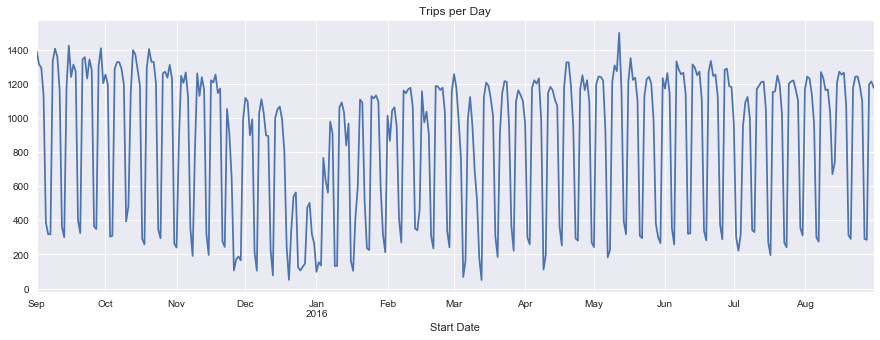

In [16]:
fig = numTrip.plot(title = 'Trips per Day', figsize = (15,5));

## Unique bikes used per day

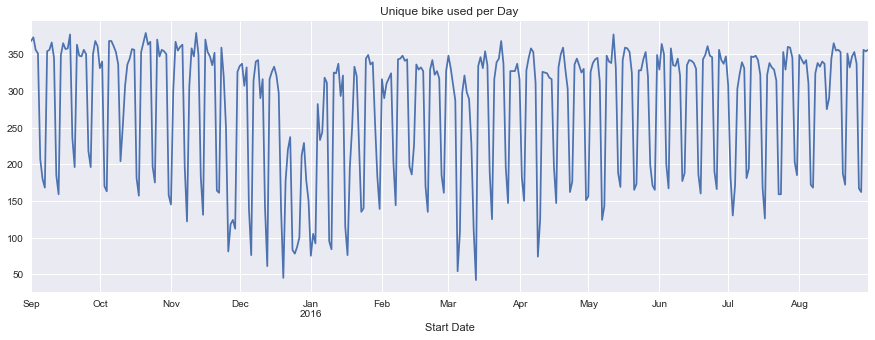

In [17]:
uniqueBike = trips.set_index('Start Date')
uniqueBike = uniqueBike.groupby(pd.TimeGrouper(freq = 'D'))['Bike #'].nunique()
uniqueBike.plot(title = 'Unique bike used per Day', figsize = (15,5));

## Bikes usage in weekdays

In [18]:
# Import calendar from pandas
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start = trips['Start Date'].min(), end = trips['Start Date'].max())

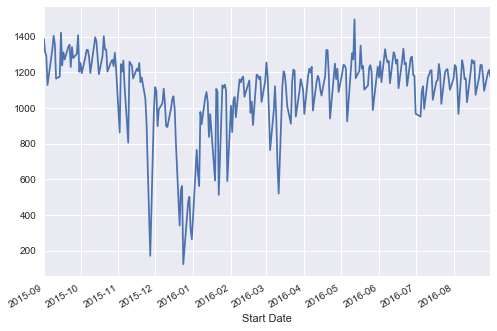

In [19]:
worktrips = trips.set_index('Start Date')
worktrips = worktrips.groupby(pd.TimeGrouper(freq = 'D')).size()
worktrips = worktrips[ worktrips.index.isin(holidays) == False ]
weekday = worktrips.index.weekday
worktrips = worktrips[weekday.isin([0,1,2,3,4])]
worktrips.plot()

The plot seems to be less noisy when eliminate holidays and weekends. However, there are still some outliers.

## Usage per day from Subscriber on Weekdays

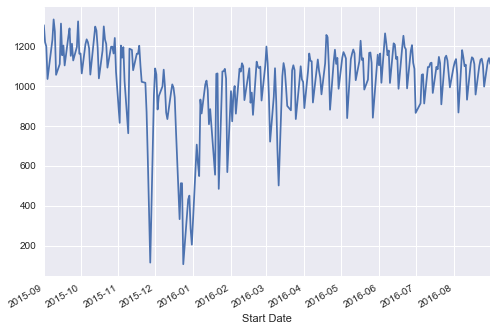

In [20]:
worktrips = trips[trips['Subscriber Type'] == 'Subscriber'].set_index('Start Date')
worktrips = worktrips.groupby(pd.TimeGrouper(freq = 'D')).size()
holiday = worktrips.index.isin(holidays)
worktrips = worktrips[ holiday == False ]
weekday = worktrips.index.weekday
worktrips = worktrips[weekday.isin([0,1,2,3,4])]
worktrips.plot()

## Usage per day from Customer

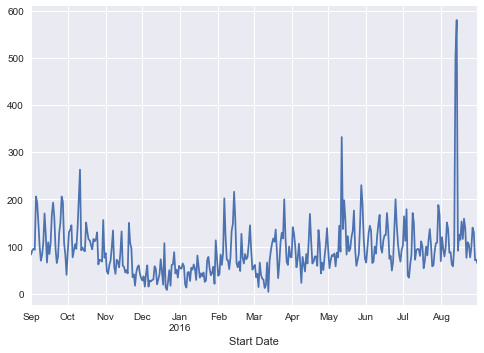

In [22]:
tripsc = trips[trips['Subscriber Type'] == 'Customer'].set_index('Start Date')
worktrips = tripsc.groupby(pd.TimeGrouper(freq = 'D')).size()
#holiday = worktrips.index.isin(holidays)
#worktrips = worktrips[ holiday == False ]
#weekday = worktrips.index.weekday
#worktrips = worktrips[weekday.isin([0,1,2,3,4])]
worktrips.plot()

## Hourly usage on weekday

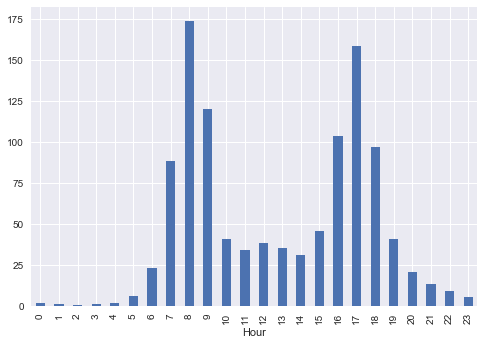

In [23]:
hourcounts = trips.set_index('Start Date')
hourcounts = hourcounts.groupby(pd.TimeGrouper(freq = 'h')).size()
holiday = hourcounts.index.isin(holidays)
worktrips = hourcounts[ holiday == False ]
weekday = hourcounts.index.weekday
hourcounts = hourcounts[weekday.isin([0,1,2,3,4])]
hourcounts = hourcounts.groupby(hourcounts.index.hour).mean()
hourcounts.index.name = 'Hour'
hourcounts.plot(kind = 'bar');

## Hourly usage on weekends

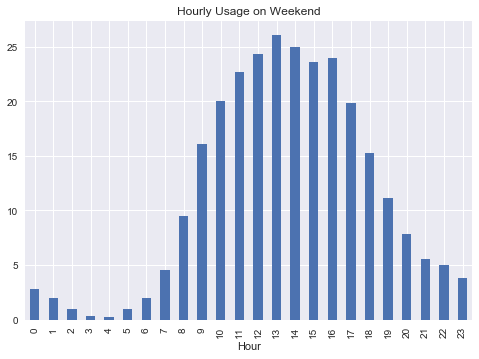

In [24]:
# Hourly usage on weekends and holidays
hourcounts = trips.set_index('Start Date')
hourcounts = hourcounts.groupby(pd.TimeGrouper(freq = 'h')).size()
#holiday = hourcounts.index.isin(holidays)
#worktrips = hourcounts[ holiday]
weekday = hourcounts.index.weekday
hourcounts = hourcounts[weekday.isin([5,6])]
hourcounts = hourcounts.groupby(hourcounts.index.hour).mean()
hourcounts.index.name = 'Hour'
hourcounts.plot(title = 'Hourly Usage on Weekend', kind = 'bar');

# Analyze trips vs. weather

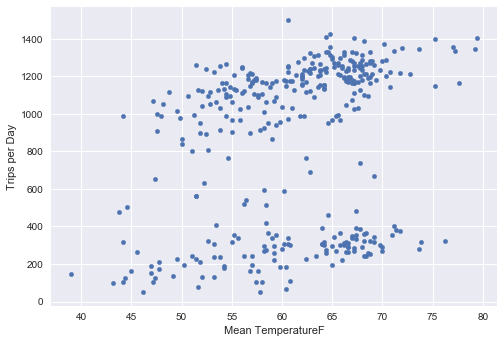

In [36]:
wt = weathers.groupby(['PDT'])['Mean TemperatureF'].mean().sort_index()
numTrip = numTrip.rename('Trips per Day')
numTriptoTemp = pd.concat([wt,numTrip], axis =1)
numTriptoTemp = numTriptoTemp.rename(index = str, columns = {"Day":"Trips per Day"})
numTriptoTemp.plot(x = 'Mean TemperatureF', y='Trips per Day', kind = 'scatter');

It seems there are two groups. The lower cluster could caused by holiday

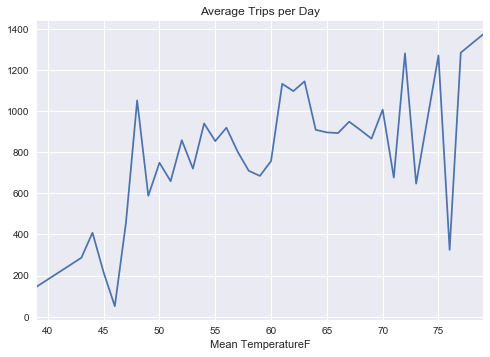

In [35]:
avgTriptoTemp = numTriptoTemp.groupby(numTriptoTemp['Mean TemperatureF']//1)['Trips per Day'].mean()
avgTriptoTemp.plot(title = 'Average Trips per Day');

This data could further exclude weekends and devide by location to have more accurate relationship

In [37]:
weathers.PrecipitationIn = weathers.PrecipitationIn.replace('T', '0.005')
weathers.PrecipitationIn = pd.to_numeric(weathers.PrecipitationIn)

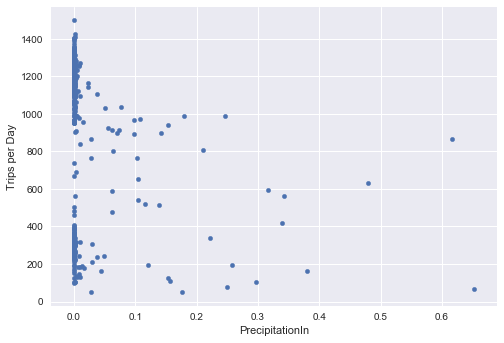

In [38]:
preci = weathers.groupby(['PDT'])['PrecipitationIn'].mean().sort_index()
numTriptoPreci = pd.concat([preci,numTrip], axis =1)
numTriptoPreci = numTriptoPreci.rename(index = str, columns = {"Day":"Trips per Day"} )
numTriptoPreci.plot(x = 'PrecipitationIn', y = 'Trips per Day', kind = 'scatter');


There's no obvious trend between trips and precipitation, probably due to the precipitation was focused in a particular area